# Differentiating weed from crop seedlings
Further info [here](https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset)

In [11]:
# general imports
import os
from pathlib import Path
import sys
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# DL
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import to_categorical

pd.set_option("display.max_columns", None)

In [2]:
print("keras version: ", keras.__version__)

keras version:  2.13.1


In [3]:
# import s3 class to read images
sys.path.append('..')
from utils.s3_class import S3Functions

In [4]:
SEED = 202407
s3_funcs = S3Functions(bucket_name='jdgallegoq-mlops')

## Load images

In [5]:
DATA_FOLDER = "v2-plant-seedlings-dataset"
train = pd.read_csv(
    s3_funcs.read_object(key=os.path.join(DATA_FOLDER, 'train.csv'))
).rename(columns={'Unnamed: 0': 'index'})
test = pd.read_csv(
    s3_funcs.read_object(key=os.path.join(DATA_FOLDER, 'test.csv'))
).rename(columns={'Unnamed: 0': 'index'})

In [6]:
# check percentages of images per clas in train and test
train['target'].value_counts(normalize=True), test['target'].value_counts(normalize=True)

(Loose Silky-bent             0.136538
 Common Chickweed             0.127059
 Scentless Mayweed            0.109456
 Small-flowered Cranesbill    0.105845
 Fat Hen                      0.095689
 Sugar beet                   0.084180
 Charlock                     0.080794
 Cleavers                     0.062288
 Black-grass                  0.055067
 Shepherds Purse              0.049199
 Maize                        0.048747
 Common wheat                 0.045137
 Name: target, dtype: float64,
 Loose Silky-bent             0.141697
 Common Chickweed             0.135379
 Scentless Mayweed            0.110108
 Fat Hen                      0.102888
 Small-flowered Cranesbill    0.096570
 Charlock                     0.084838
 Sugar beet                   0.081227
 Black-grass                  0.058664
 Cleavers                     0.053249
 Shepherds Purse              0.050542
 Common wheat                 0.047834
 Maize                        0.037004
 Name: target, dtype: float64)

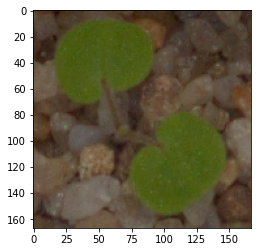

In [7]:
# plot a sample image
img = s3_funcs.read_image(key=train.image[0], asarray=False)
plt.imshow(img)

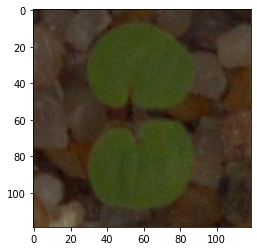

In [8]:
img = s3_funcs.read_image(key=train.image[47], asarray=False)
plt.imshow(img)

## Prepare data

In [10]:
X_train = train['image']
y_train = train['target']
X_test = test['image']
y_test = test['target']

encoder = LabelEncoder()
encoder.fit(y_train)
train_y = to_categorical(encoder.transform(y_train))
test_y = to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [16]:
# images should be reshaped
IMAGE_SIZE = 150

def create_dataset(df, image_size):
    tmp = np.zeros((len(df), image_size, image_size, 3), dtype='float32')
    for n in range(0, len(df)):
        img = resize(
            image=s3_funcs.read_image(
            key=df[n]
            ),
            output_shape=(image_size, image_size)
        )
        tmp[n] = img
        
        print("dataset images shape: {} size: {:,}".format(tmp.shape, tmp.size))
        return tmp

In [17]:
x_train = create_dataset(X_train, IMAGE_SIZE)

dataset images shape: (4431, 150, 150, 3) size: 299,092,500


In [18]:
x_test = create_dataset(X_test, IMAGE_SIZE)

dataset images shape: (1108, 150, 150, 3) size: 74,790,000


## Model arquitecture

In [20]:
# following course material
kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

In [21]:
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation='softmax')) # 12 are the target label numbers

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                        

## Compile and train

In [ ]:
model.compile(
    Adam(lr=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# define batch size and epochs for training
batch_size = 10
epochs = 8

try:
    os.mkdir('../module/models')
except FileExistsError:
    pass
filepath = "../module/models/model.h5"
# checkpoint by accuracy
checkpoint = ModelCheckpoint(
    filepath,
    monitor='acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)
reduce_lr = ReduceLROnPlateau(
    monitor='acc',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='max',
    min_lr=1e-5
)

# define callbacks
callbacks_list = [checkpoint, reduce_lr]

# train
history = model.fit(
    x=x_train,
    y=train_y,
    batch_size=batch_size,
    validation_split=10,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks_list
)

## Evaluate

In [ ]:
acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(acc)+1)

# plot loss
plt.plot(epochs, loss, 'bo' label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()
# plot accuracy
plt.plot(epochs, acc, 'bo', label='Taining accuracy')
plt.title()
plt.legend()
plt.figure()

In [ ]:
# get predictions
preds = model.predict_classes(x_test, verbose=1)
print(preds)
# transform target
print(encoder.transform(y_test))

In [ ]:
# explore metrics
conf_matrix = confusion_matrix(
    encoder.transform(y_test),
    preds
)

# create a dict to map back numbers onto classes
tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis=1)
tmp.columns = ['class_name', 'class_number']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = pd.Series(tmp.class_name.values, index=tmp.class_number).to_dict()
tmp

In [ ]:
# these we will display in the below matrix
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

# plot consuffusion matrix
fig, ax = plt.subplots(1)
ax = sns.heatmap(conf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confussion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
accuracy_score(
    encoder.transform(y_test),
    preds,
    normalize=True,
    sample_weight=None
)
print(classification_report(encoder.transform(y_test), preds))